In [1]:
class FastNewman:
    def __init__(self, path):
        self.G = G_name2id(path)
        # G = nx.read_gml('dolphins.gml')
        self.A = nx.to_numpy_array(self.G)
        self.num_node = len(self.A)
        self.num_edge = sum(sum(self.A))  # 边数
        self.c = {}  # 记录所有Q值对应的社团分布


    def merge_community(self, iter_num, detaQ, e, b):
        (I, J) = np.where(detaQ == np.amax(detaQ))
        for m in range(len(I)):
            e[J[m], :] = e[I[m], :] + e[J[m], :]
            e[I[m], :] = 0
            e[:, J[m]] = e[:, I[m]] + e[:, J[m]]
            e[:, I[m]] = 0
            b[J[m]] = b[J[m]] + b[I[m]]

        e = np.delete(e, I, axis=0)
        e = np.delete(e, I, axis=1)
        I = sorted(list(set(I)), reverse=True)
        for i in I:
            b.remove(b[i])  # 删除第I组社团，（都合并到J组中了）
        self.c[iter_num] = b.copy()
        return e, b


    def Run_FN(self):
        e = self.A / self.num_edge  # 社区i,j连边数量占总的边的比例
        a = np.sum(e, axis=0)  # e的列和，表示与社区i中节点相连的边占总边数的比例
        b = [[i] for i in range(self.num_node)]  # 本轮迭代的社团分布
        Q = []
        iter_num = 0
        while len(e) > 1:
            num_com = len(e)
            detaQ = -np.power(10, 9) * np.ones((self.num_node, self.num_node))  # detaQ可能为负数，初始设为负无穷
            for i in range(num_com - 1):
                for j in range(i + 1, num_com):
                    if e[i, j] != 0:
                        detaQ[i, j] = 2 * (e[i, j] - a[i] * a[j])
            if np.sum(detaQ + np.power(10, 9)) == 0:
                break

            e, b = self.merge_community(iter_num, detaQ, e, b)

            a = np.sum(e, axis=0)
            # 计算Q值
            Qt = 0.0
            for n in range(len(e)):
                Qt += e[n, n] - a[n] * a[n]
            Q.append(Qt)
            iter_num += 1
        max_Q, community = self.get_community(Q)
        return max_Q, community


    def get_community(self, Q):
        max_k = np.argmax(Q)
        community = self.c[max_k]
        return Q[max_k], community



In [2]:
def G_name2id(path):
    '''
    将graph的name转换为数字id（id从0开始）

    path:（源点、端点）文件路径
    '''
    G = nx.read_edgelist(path, delimiter=',')
    N = dict.fromkeys(G.nodes())  # node_id
    i = 0
    for name, id in N.items():
        N[name] = i
        i = i+1

    G_n = nx.Graph()
    with open(path,'r') as f:
        lines = f.readlines()
    for line in lines:
        n = line.strip().split(',')
        G_n.add_edge(N[n[0]],N[n[1]])

    return G_n


In [3]:
def get_value(G, community):
    '''
    Each node gets respective value. Nodes in one community have same value
    community: 形如 [[1,2,3],[4,5],[6,7,8]]
    '''
    num_node = nx.number_of_nodes(G)
    value = [[] for i in range(num_node)]
    for index, com in enumerate(community):
        for q in com:
            value[q] = index
    return value


def draw_community(G, com):
    value = get_value(G, com)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_color=value, node_size=20)
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)
    plt.show()
    # plt.savefig('community.jpg')


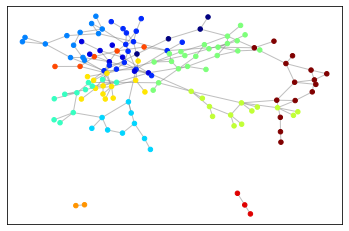

In [8]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt 
Q, community = FastNewman('Graph.csv').Run_FN()
G = G_name2id('Graph.csv')
draw_community(G, community)
